<a href="https://colab.research.google.com/github/kyllianj/M2_Data_Mining/blob/main/Support_Vector_Machines_for_novelty_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD on Support Vector Machines for novelty detection OCSVM / SVDD (part 2)

### Usage of this notebook
- __run a cell__ with **_ctrl-enter_** or **_shift-enter_**
- __use the command palette__ with **_ctrl-shift-P_** to find more complex commands

Use it referably with __Edge__ or __Chrome__



In [1]:
import os
import time
from google.colab import drive

#Some typical scientific & data manipulation packages
import numpy as np
import pandas as pd

#Imports from sklearn package
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

# **Exercise 1. Test the One Class SVM algorithm on a random dataset**
Let's generate a random dataset to visualize how the different parameters of one class SVM impact on outlier detection, please check the package here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

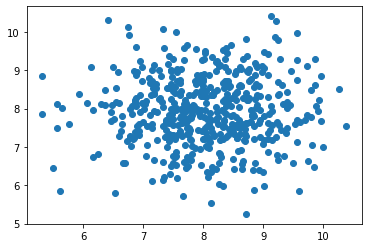

In [2]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=500, centers=1, cluster_std=.9, center_box=(8, 8))
plt.scatter(X[:,0], X[:,1])
plt.show()

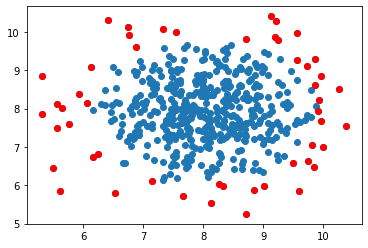

In [14]:
#Write your detector with the OneClassSVM function from sklearn
#Play with the different parameters to get an intuition on their action

ocsvm = OneClassSVM(gamma = 0.01, nu = 0.1).fit(X)
#gamma can be change too
#nu to change the number of anomalies

pred = ocsvm.fit_predict(X)

anom_index = np.where(pred==-1)
anomalies = X[anom_index]

plt.scatter(X[:,0], X[:,1])
plt.scatter(anomalies[:,0], anomalies[:,1], color='r')
plt.show()

# **Exercise 2. Let's test some anomaly detection algorithms to detect credit card fraud**
Please dowload the dataset here: https://cutt.ly/c1zKuTX

The dataset summarizes credit card transactions that happened in 2 days in 2013 in Europe. 'Class' corresponds to the target (i.e. Class = 1 if the transaction is a fraud). For confidentiality concerns, features V1 to V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are:
- 'Time': contains the seconds elapsed between each transaction and the first transaction in the dataset
- 'Amount': the amount in € of the transaction

To know more about this dataset please check: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

### 1.1. Load the dataset

In [25]:
#Get the current location of your notebook
print(os.getcwd())

#Connect to your drive
drive.mount(os.getcwd()+'/drive')

#To navigate and list content of your Drive folders
print(os.listdir('drive/'))
print(os.listdir('drive/MyDrive'))

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.shortcut-targets-by-id', '.file-revisions-by-id', 'MyDrive', '.Trash-0']
['Document sans titre.gdoc', 'Copie de M1 APE_Sujets_étude_UE 2.gsheet', "Convention Partenariat Spacer's BDE 2022-2023.pdf", 'Colab Notebooks', 'creditcard.csv']


In [24]:
df_cc = pd.read_csv("drive/MyDrive/creditcard.csv")
df_cc

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,16.0,0.694885,-1.361819,1.029221,0.834159,-1.191209,1.309109,-0.878586,0.445290,-0.446196,...,-0.295583,-0.571955,-0.050881,-0.304215,0.072001,-0.422234,0.086553,0.063499,231.71,0
1,34.0,1.138316,0.056956,0.649419,0.873062,-0.468466,-0.410195,-0.013898,-0.072440,0.306788,...,-0.164222,-0.247401,0.059405,0.456286,0.361004,0.274414,-0.002498,0.017109,21.34,0
2,60.0,1.069141,0.043786,0.309867,1.316694,-0.462394,-0.857888,0.207904,-0.191270,0.056398,...,0.115775,0.164781,-0.177564,0.391891,0.624682,-0.288376,-0.001312,0.035812,89.40,0
3,64.0,1.212511,-0.099054,-1.192094,0.286324,2.160516,3.616314,-0.404207,0.842331,0.169360,...,-0.167496,-0.494695,-0.149785,1.011227,0.883548,-0.329434,0.020370,0.017037,34.70,0
4,77.0,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,...,-0.201681,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,9.12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20487,172733.0,-1.655706,0.003114,-1.033249,-0.869445,3.343411,3.327608,-0.045678,1.139503,-0.272902,...,-0.235610,-0.633347,-0.038226,0.602366,0.690722,0.206904,-0.306675,-0.248686,40.78,0
20488,172734.0,2.038742,0.052438,-1.821291,0.241283,0.580419,-0.392388,0.063043,-0.053268,0.304700,...,-0.331870,-0.918065,0.288450,0.176938,-0.262765,0.172902,-0.070469,-0.043095,8.99,0
20489,172762.0,-0.725459,0.194981,-1.785571,-3.779860,2.177420,2.975713,-0.239695,0.912303,-3.159994,...,0.046103,0.102480,-0.461027,0.717647,1.253036,0.207138,-0.630549,-0.163911,7.00,0
20490,172771.0,-0.515513,0.971950,-1.014580,-0.677037,0.912430,-0.316187,0.396137,0.532364,-0.224606,...,-0.280302,-0.849919,0.300245,0.000607,-0.376379,0.128660,-0.015205,-0.021486,9.81,0


### 1.2. Explore the dataset

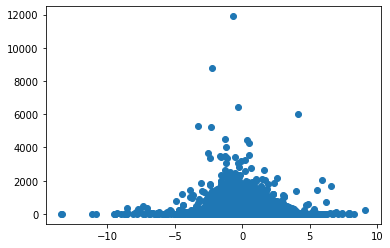

In [26]:
plt.figure()
plt.scatter(df_cc.V9, df_cc.Amount)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


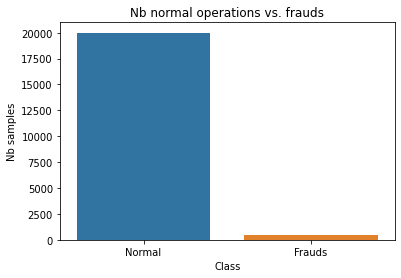

Total number of anomalies: 492
Ratio of anomalies: 0.024009369510052704


In [27]:
#Check how imbalanced the dataset is
sns.countplot(df_cc.Class)
plt.ylabel('Nb samples')
plt.xticks(np.arange(2), ['Normal','Frauds'])
plt.title("Nb normal operations vs. frauds")
plt.show()

print("Total number of anomalies:", list(df_cc.Class).count(1))
print("Ratio of anomalies:", list(df_cc.Class).count(1)/len(df_cc))

### 1.3. Preprocessing

In [28]:
#Keep columns for later (you need to save your labels in a variable since we are not supposed to know it and you might not want use all the variables)
Time = df_cc.Time
labels = df_cc.Class
del df_cc["Class"]
del df_cc["Time"]

In [30]:
#[OPTIONAL] Normalize each column except time & class (you can use MinMaxScaler from sklearn.preprocessing for instance)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_cc)
df_scaled = pd.DataFrame(scaled, columns = df_cc.columns)

df_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,...,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000,20492.000000
mean,0.932408,0.686483,0.883217,0.320722,0.526092,0.493654,0.578442,0.672509,0.593219,0.647683,...,0.454662,0.456290,0.515678,0.669809,0.416057,0.629145,0.364992,0.526444,0.346962,0.007634
std,0.062173,0.027335,0.060370,0.091474,0.029365,0.032098,0.024221,0.025549,0.053843,0.041165,...,0.018345,0.018413,0.043521,0.010945,0.089111,0.032814,0.106952,0.027254,0.015145,0.021553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.910074,0.677109,0.860336,0.268214,0.514700,0.476073,0.572320,0.668849,0.566088,0.636195,...,0.449642,0.451532,0.484387,0.667385,0.363470,0.609702,0.293457,0.522040,0.344625,0.000447
50%,0.934996,0.686663,0.892173,0.316020,0.526131,0.487955,0.580496,0.672744,0.592618,0.648184,...,0.453030,0.455519,0.516070,0.669675,0.422456,0.629929,0.352210,0.526386,0.347283,0.001863
75%,0.970203,0.697593,0.916661,0.361596,0.538073,0.503496,0.587624,0.677816,0.620980,0.662288,...,0.457555,0.459921,0.546511,0.672064,0.480752,0.650700,0.418976,0.532161,0.350216,0.006640
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
#Modify labels
labels = np.where(labels == 1, -1, 1)
#Replace anamolies by -1 and also replace 0 by 1

### 1.4. Try with [One Class SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)


In [40]:
#Try one class SVM with all dataset at once
start_time = time.time()

#Here we know that the ratio of anomalies is around 0.02 so nu = 0.02
ocsvm = OneClassSVM(gamma = 0.001, nu = 0.02, coef0 = 0.1, shrinking = False, cache_size = 200, max_iter = 1).fit(df_scaled)

prediction = ocsvm.fit_predict(df_scaled)

print("Processing_duration =", round(time.time() - start_time, 2), "s")

#Check performance
print("Accuracy=", accuracy_score(labels, prediction))
print("Precision=", precision_score(labels, prediction))
print("Recall=", recall_score(labels, prediction))
print("F1 score =", f1_score(labels, prediction))
cf_matrix = confusion_matrix(labels, prediction)
cf_matrix
#Play with the gamma and the nu to get better confusion matrix

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Processing_duration = 3.71 s
Accuracy= 0.9402693734140152
Precision= 0.9958276117038133
Recall= 0.94275
F1 score = 0.968562182154415


array([[  413,    79],
       [ 1145, 18855]])

### 1.4. Try with [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#:~:text=sklearn.neighbors%20.LocalOutlierFactor%20%C2%B6.%20The%20anomaly%20score%20of%20each,object%20is%20with%20respect%20to%20the%20surrounding%20neighborhood.)


In [41]:
start_time = time.time()

lof = LocalOutlierFactor(n_neighbors=50, algorithm="auto").fit(df_scaled)

prediction = lof.fit_predict(df_scaled)

#Measure performances
print("Processing_duration =", round(time.time() - start_time, 2), "s\n")
print("Accuracy=", accuracy_score(labels, prediction))
print("Precision=", precision_score(labels, prediction))
print("Recall=", recall_score(labels, prediction))
print("F1 score =", f1_score(labels, prediction))
confusion_matrix(labels, prediction)
#More complex to play with options

Processing_duration = 25.75 s

Accuracy= 0.9472965059535429
Precision= 0.9775365976779404
Recall= 0.96825
F1 score = 0.972871137905049


array([[   47,   445],
       [  635, 19365]])

### 1.5. Try with [Isolation Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [42]:
start_time = time.time()

ifo = IsolationForest(random_state=0).fit(df_scaled)

prediction = ifo.fit_predict(df_scaled)

#Measure performances
print("Processing_duration =", round(time.time() - start_time, 2), "s\n")
print("Accuracy=", accuracy_score(labels, prediction))
print("Precision=", precision_score(labels, prediction))
print("Recall=", recall_score(labels, prediction))
print("F1 score =", f1_score(labels, prediction))
confusion_matrix(labels, prediction)
#This one is the best

Processing_duration = 2.5 s

Accuracy= 0.9683779035721257
Precision= 0.9929692276339922
Recall= 0.9745
F1 score = 0.9836479257090947


array([[  354,   138],
       [  510, 19490]])

# **Exercise 3. Teamwork on network anomaly detection and attack classification**

Please download the dataset here: https://cutt.ly/z1cUDLC

You will find more information on the dataset in this document: https://cutt.ly/J1zKzqL

This dataset aims at finding potential hacker's attacks based on some network traffic metrics and ideally to classify them. 

It is a double problem: 
- first you need to distinguish whether the sample is normal or anomalous
- then, if it is an anomaly we should classify them into the different categories

For this exercise, you are allowed to have a training phase and even to use part of your training dataset to optimize your anomaly detection algorithm hyperparameters. You might want to reduce the size of the dataset if the run take too much time, please explain your method.

You can pick any combination of unsupervised & supervised technique you want, e.g.: 
- one-class SVM & SVM classifier
- Isolation Forests & Random Forest
- etc.

The goal is to obtain the best results!

In [47]:
df_nwk = pd.read_csv("drive/MyDrive//cyberattacks.csv")
#Keep original labels
labels = df_nwk['attack']
#Transform to binary labels 
binary_labels = np.where(labels == 'normal', 1, -1)
#Remove labels
del df_nwk["attack"]
df_nwk

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,http,SF,222,623,0,0,0,0,...,255,1.00,0.00,0.20,0.04,0.0,0.0,0.0,0.0,21
1,0,tcp,http,SF,228,14408,0,0,0,0,...,255,1.00,0.00,0.05,0.01,0.0,0.0,0.0,0.0,21
2,0,tcp,http,SF,318,6652,0,0,0,0,...,255,1.00,0.00,0.12,0.07,0.0,0.0,0.0,0.0,21
3,0,tcp,ftp_data,SF,1363,0,0,0,0,0,...,71,0.34,0.03,0.34,0.00,0.0,0.0,0.0,0.0,20
4,0,tcp,smtp,SF,1627,332,0,0,0,0,...,204,0.77,0.02,0.01,0.01,0.0,0.0,0.0,0.0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,19
21996,0,udp,private,SF,28,0,0,3,0,0,...,79,0.31,0.01,0.31,0.00,0.0,0.0,0.0,0.0,16
21997,0,tcp,bgp,REJ,0,0,0,0,0,0,...,3,0.01,0.07,0.00,0.00,0.0,0.0,1.0,1.0,20
21998,0,tcp,ftp_data,S0,0,0,0,0,0,0,...,9,0.04,0.05,0.00,0.00,1.0,1.0,0.0,0.0,20


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


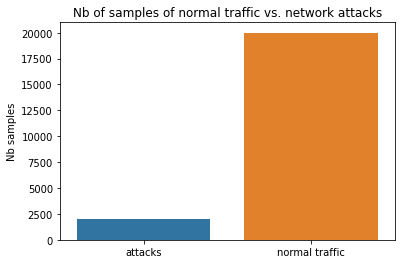

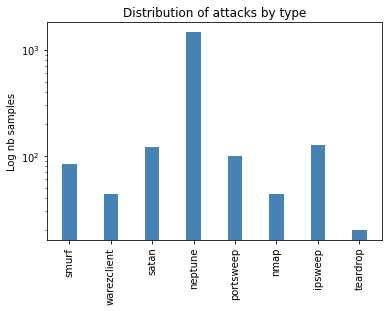

In [48]:
#Observe your dataset
sns.countplot(binary_labels)
plt.ylabel('Nb samples')
plt.xticks(np.arange(2), ['attacks','normal traffic'])
plt.title("Nb of samples of normal traffic vs. network attacks")
plt.show()

attacks = [i for i in labels if i!="normal"]
attacks_count = [attacks.count(i) for i in set(attacks)]
bins = np.arange(len(attacks_count))
fig, ax = plt.subplots()
plt.bar(bins, attacks_count, 0.35, log=True, color='steelblue')
plt.ylabel('Log nb samples')
plt.xticks(bins, set(attacks), rotation=90)
plt.title("Distribution of attacks by type")
plt.show()

In [53]:
#[OPTIONAL] If you use the categorical columns don't hesitate to one hot encode them (use pandas.get_dummies)
df_nwk_dummies = pd.get_dummies(df_nwk)
df_nwk_dummies

#[OPTIONAL] You can also normalize/standardize the dataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_nwk_dummies)
df_scaled = pd.DataFrame(scaled, columns = df_nwk_dummies.columns)

df_scaled.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,...,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000,22000.000000
mean,0.004885,0.000582,0.000874,0.000136,0.000909,0.000045,0.005205,0.000439,0.651045,0.000223,...,0.050318,0.004909,0.000136,0.005818,0.060091,0.005227,0.001636,0.000591,0.870864,0.000318
std,0.040982,0.010976,0.015384,0.011677,0.030138,0.006742,0.052689,0.015070,0.476650,0.009477,...,0.218606,0.069894,0.011677,0.076057,0.237661,0.072112,0.040420,0.024302,0.335358,0.017835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000002,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000012,0.000065,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000017,0.000360,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
#Unsupervised anomaly detection
start_time = time.time()

ifo = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', 
                      max_features=1.0, bootstrap=False, n_jobs=None, random_state=0, 
                      verbose=0, warm_start=False).fit(df_scaled)

prediction = ifo.fit_predict(df_scaled)

#Measure performances
print("Processing_duration =", round(time.time() - start_time, 2), "s\n")
print("Accuracy=", accuracy_score(binary_labels, prediction))
print("Precision=", precision_score(binary_labels, prediction))
print("Recall=", recall_score(binary_labels, prediction))
print("F1 score =", f1_score(binary_labels, prediction))
confusion_matrix(binary_labels, prediction)

Processing_duration = 6.32 s

Accuracy= 0.9200909090909091
Precision= 0.9305608006042296
Recall= 0.98565
F1 score = 0.9573135198135199


array([[  529,  1471],
       [  287, 19713]])

In [ ]:
#Evaluate your anomaly detector


In [ ]:
#Supervised attack classification


In [ ]:
#Evaluate your classifier
